# ACC Prediction Test

## Setup

### 1. Import Packages

In [1]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [26]:
# Imports and Configurations
import os
import cv2
import imghdr
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, ConvNeXtTiny
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
import optuna
from optuna import Trial
from sklearn.metrics import classification_report
from tensorflow.keras.models import save_model

In [27]:
# Configure GPU settings
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [28]:
# Constants
data_dir = 'data'  # The directory where your data resides
output_dir = 'output'  # The directory to save output files
image_exts = ['jpeg', 'jpg', 'bmp', 'png']  # Valid image file extensions
batch_size = 32  # Batch size for training
epochs = 25  # Number of training epochs
optuna_n_trials = 25  # Number of trials for Optuna optimization
augmentation_multiplier = 5 # How many augmented images we want to get from each training example
base_model_trainable = True # Whether we should be able to train base layers of pretrained models

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [29]:
tf.config.list_physical_devices('GPU')

[]

### 2. Remove Unwanted images

In [30]:
# Remove non-image files and corrupted images
def preprocess_images(data_dir, image_exts):
    """
    Removes non-image files and corrupted images from data directories.
    
    Parameters:
        data_dir (str): The root directory containing the image data.
        image_exts (list): List of valid image file extensions.
    """
    for image_class in os.listdir(data_dir):
        class_path = os.path.join(data_dir, image_class)
        if not os.path.isdir(class_path):
            continue

        for image in os.listdir(class_path):
            image_path = os.path.join(class_path, image)
            if not os.path.isfile(image_path):
                continue

            try:
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    os.remove(image_path)
            except Exception as e:
                print(f'Issue with image {image_path}: {e}. Removing it.')
                os.remove(image_path)

preprocess_images(data_dir, image_exts)

## Data Handling

### 1. Load Data

In [31]:
# Load and visualize the dataset
data = tf.keras.preprocessing.image_dataset_from_directory(data_dir, image_size=(224, 224), batch_size=batch_size)

Found 1581 files belonging to 3 classes.


In [32]:
data_iterator = data.as_numpy_iterator()

In [33]:
batch = data_iterator.next()

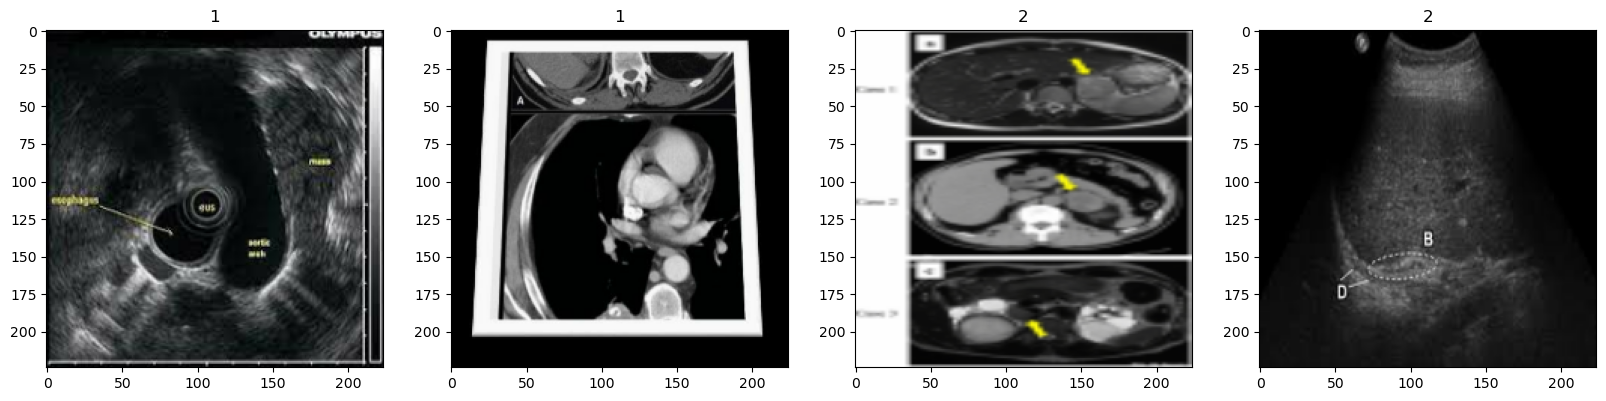

In [34]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [35]:
data.as_numpy_iterator().next()

(array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [1.76020339e-01, 1.76020339e-01, 1.76020339e-01],
          ...,
          [7.11454163e+01, 7.11454163e+01, 7.11454163e+01],
          [7.15382843e+01, 7.15382843e+01, 7.15382843e+01],
          [7.01224213e+01, 7.01224213e+01, 7.01224213e+01]],
 
         [[6.65816367e-01, 6.65816367e-01, 6.65816367e-01],
          [1.45408124e-01, 1.45408124e-01, 1.45408124e-01],
          [7.04081357e-01, 7.04081357e-01, 7.04081357e-01],
          ...,
          [6.98903046e+01, 6.98903046e+01, 6.98903046e+01],
          [7.09872971e+01, 7.09872971e+01, 7.09872971e+01],
          [7.21198502e+01, 7.21198502e+01, 7.21198502e+01]],
 
         [[4.43877697e-01, 4.43877697e-01, 4.43877697e-01],
          [9.69387740e-02, 9.69387740e-02, 9.69387740e-02],
          [7.24489927e+00, 7.24489927e+00, 7.24489927e+00],
          ...,
          [7.07678528e+01, 7.07678528e+01, 7.0767

### 2. Data Augmentation, Train/Val/Test Split, and Scaling

In [36]:
# Fetch all image file paths
image_paths = []
labels = []
for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)
    for image in os.listdir(class_path):
        image_paths.append(os.path.join(class_path, image))
        labels.append(image_class)

In [37]:
# Split the data
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.2)

In [38]:
### 2. Data Augmentation, Train/Val/Test Split, and Scaling

# Initialize the ImageDataGenerator class for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5]
)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_paths, 'class': train_labels}),
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

def infinite_loop_generator(generator):
    while True:
        for data in generator:
            yield data

infinite_train_gen = infinite_loop_generator(train_gen)

# Initialize the ImageDataGenerator class for validation and test sets (No Augmentation)
val_test_datagen = ImageDataGenerator(
    rescale=1./255
)


# Create a validation data generator (similar to the training data generator)
val_gen = val_test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_paths, 'class': val_labels}),
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

# Create a test data generator (similar to the training and validation data generators)
test_gen = val_test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': test_paths, 'class': test_labels}),
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

# Number of original batches
original_steps = len(train_gen)

# Increase steps_per_epoch to 5 times to augment each original image 5 times
total_train_samples = len(train_paths)
augmented_steps = (total_train_samples // batch_size) * augmentation_multiplier

Found 1009 validated image filenames belonging to 2 classes.
Found 252 validated image filenames belonging to 2 classes.
Found 317 validated image filenames belonging to 2 classes.


C:\Users\balam\anaconda3\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
C:\Users\balam\anaconda3\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


## Model Handling

### 1. Define classification report and evaluation metrics

In [39]:
def flatten_nested_dict(d, parent_key='', sep='-'):
    """
    Flattens a nested dictionary.
    
    Parameters:
        d (dict): Dictionary to flatten.
        parent_key (str, optional): The parent key for nested items. Defaults to ''.
        sep (str, optional): The separator to use between keys. Defaults to '-'.

    Returns:
        dict: Flattened dictionary.
    """
    items = {}
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.update(flatten_nested_dict(v, new_key, sep=sep))
        else:
            items[new_key] = v
    return items

In [40]:
def fast_evaluate_metrics(generator, model):
    """
    Quickly evaluates model metrics using the provided data generator.

    Parameters:
        generator (ImageDataGenerator): Data generator for evaluation.
        model (tf.keras.Model): The trained model.

    Returns:
        dict: Dictionary containing loss, accuracy, precision, and recall.
    """
    loss, accuracy, precision, recall = model.evaluate(generator, verbose=0)
    
    return {
        'Loss': loss,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    }

def calculate_metrics(model, train_generator, val_generator, test_generator):
    """
    Calculates metrics for training, validation, and test datasets.

    Parameters:
        model (tf.keras.Model): The trained model.
        train_generator, val_generator, test_generator: Data generators for different sets.

    Returns:
        dict: Flattened dictionary containing all metrics.
    """
    metrics = {}
    for dataset, generator in {'train': train_generator,
                               'val': val_generator,
                               'test': test_generator}.items():
        metrics[dataset] = fast_evaluate_metrics(generator=generator, model=model)
    metrics = flatten_nested_dict(metrics)
    return metrics

In [41]:
def save_metrics_to_excel(model, model_name,
                          train_generator, val_generator, test_generator,
                          special_params = {},
                          model_type='', 
                          filename=os.path.join(output_dir, 'model_metrics.xlsx'),
                          override=False):
    """
    Save model metrics, model name, and number of parameters to Excel.

    Parameters:
        model (tf.keras.Model): Trained model.
        train_generator, val_generator, test_generator: Data generators for different sets.
        special_params (dict): a dictionary for trial params, if model is of type "Optuna".
        filename (str): Name of the Excel file.
        model_name (str): Name of the new model we're saving in our log file.
        override (bool): Whether to override the existing file or append to it.

    """
    
    # Update the all_info dictionary to include metrics
    all_info = {'Model Name': model_name, 
                'Number of Parameters': model.count_params(),
                'Special Parameters': special_params}
    
    # add metrics to output dictionary
    all_info.update(calculate_metrics(model=model,
                                      train_generator=train_gen,
                                      val_generator=val_gen,
                                      test_generator=test_gen))

    # Convert the dictionary to a DataFrame
    new_df = pd.DataFrame([all_info])

    # Check if the Excel file already exists and don't override
    if os.path.exists(filename) and not override:
        # If it does, read it into a DataFrame
        df = pd.read_excel(filename)

        # Append the new DataFrame to the existing DataFrame
        df = pd.concat([df, new_df], ignore_index=True)
    else:
        df = new_df

    # Save the DataFrame to Excel
    df.to_excel(filename, index=False)

In [42]:
class F1ScoreCallback(Callback):
    """
    Callback to compute F1 score at the end of each epoch.
    """
    def on_epoch_end(self, epoch, logs={}):
        precision = logs.get('val_precision')
        recall = logs.get('val_recall')
        if precision is not None and recall is not None and precision + recall > 0:
            f1_score = 2 * (precision * recall) / (precision + recall)
            print(f" - val_f1_score: {f1_score}")

### 2. Create DL Models (Pretrained)

In [43]:
# Fine-tuning a Pretrained Model (VGG16)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = base_model_trainable

# Adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model_vgg = Model(inputs=base_model.input, outputs=predictions)

# Setting up callbacks
lr_scheduler_callback = LearningRateScheduler(lambda epoch: 0.001 * 0.9 ** epoch)
checkpoint_callback = ModelCheckpoint('vgg_best_model.h5', save_best_only=True)
tensorboard_callback = TensorBoard(log_dir='vgg_logs')
f1_callback = F1ScoreCallback()

# Compile the model and display a summary
optimizer = Adam(learning_rate=0.001)
model_vgg.compile(optimizer=optimizer, 
                  loss=tf.losses.BinaryCrossentropy(), 
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
model_vgg.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [44]:
# Fine-tuning a Pretrained Model (ResNet50)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = base_model_trainable

# Adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model_resnet = Model(inputs=base_model.input, outputs=predictions)

# Setting up callbacks
lr_scheduler_callback = LearningRateScheduler(lambda epoch: 0.001 * 0.9 ** epoch)
checkpoint_callback = ModelCheckpoint('resnet50_best_model.h5', save_best_only=True)
tensorboard_callback = TensorBoard(log_dir='resnet50_logs')

# Compile and summary
optimizer = Adam(learning_rate=0.001)
model_resnet.compile(optimizer=optimizer, 
                  loss=tf.losses.BinaryCrossentropy(), 
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
model_resnet.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [45]:
# Fine-tuning a Pretrained Model (MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = base_model_trainable

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model_mobilenet = Model(inputs=base_model.input, outputs=predictions)

# Callbacks
lr_scheduler_callback = LearningRateScheduler(lambda epoch: 0.001 * 0.9 ** epoch)
checkpoint_callback = ModelCheckpoint('mobilenetv2_best_model.h5', save_best_only=True)
tensorboard_callback = TensorBoard(log_dir='mobilenetv2_logs')

# Compile and summary
optimizer = Adam(learning_rate=0.001)
model_mobilenet.compile(optimizer=optimizer, 
                  loss=tf.losses.BinaryCrossentropy(), 
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
model_mobilenet.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_7[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [46]:
# Fine-tuning a Pretrained Model (ConvNeXtTiny)
base_model = ConvNeXtTiny(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = base_model_trainable

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model_convnext = Model(inputs=base_model.input, outputs=predictions)

# Callbacks
lr_scheduler_callback = LearningRateScheduler(lambda epoch: 0.001 * 0.9 ** epoch)
checkpoint_callback = ModelCheckpoint('mobilenetv2_best_model.h5', save_best_only=True)
tensorboard_callback = TensorBoard(log_dir='mobilenetv2_logs')

# Compile and summary
optimizer = Adam(learning_rate=0.001)
model_convnext.compile(optimizer=optimizer, 
                  loss=tf.losses.BinaryCrossentropy(), 
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
model_convnext.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 convnext_tiny_prestem_norm  (None, 224, 224, 3)          0         ['input_8[0][0]']             
 alization (Normalization)                                                                        
                                                                                                  
 convnext_tiny_stem (Sequen  (None, 56, 56, 96)           4896      ['convnext_tiny_prestem_normal
 tial)                                                              ization[0][0]']               
                                                                                            

### 3. Fine-Tune Pretrained Models

In [ ]:
hist_vgg = model_vgg.fit(
    infinite_train_gen,
    epochs=epochs,
    steps_per_epoch=augmented_steps,
    validation_data=val_gen,
    callbacks=[lr_scheduler_callback, checkpoint_callback, tensorboard_callback, f1_callback])

Epoch 1/25
  2/155 [..............................] - ETA: 36:35 - loss: 5.0564 - accuracy: 0.4844 - precision: 0.3750 - recall: 0.4800          

C:\Users\balam\anaconda3\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


155/155 [==============================] - ETA: 0s - loss: 0.7705 - accuracy: 0.5771 - precision: 0.4265 - recall: 0.0571 

C:\Users\balam\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


155/155 [==============================] - 2188s 14s/step - loss: 0.7705 - accuracy: 0.5771 - precision: 0.4265 - recall: 0.0571 - val_loss: 0.6813 - val_accuracy: 0.6032 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/25
 47/155 [========>.....................] - ETA: 26:09 - loss: 0.6787 - accuracy: 0.5889 - precision: 0.0000e+00 - recall: 0.0000e+00

In [ ]:
hist_resnet = model_resnet.fit(
    infinite_train_gen,
    epochs=epochs,
    steps_per_epoch=augmented_steps,
    validation_data=val_gen,
    callbacks=[lr_scheduler_callback, checkpoint_callback, tensorboard_callback, f1_callback]
)

In [ ]:
hist_mobilenet = model_mobilenet.fit(
    infinite_train_gen,
    epochs=epochs,
    steps_per_epoch=augmented_steps,
    validation_data=val_gen,
    callbacks=[lr_scheduler_callback, checkpoint_callback, tensorboard_callback, f1_callback])

In [ ]:
hist_convnext = model_convnext.fit(
    infinite_train_gen,
    epochs=epochs,
    steps_per_epoch=augmented_steps,
    validation_data=val_gen,
    callbacks=[lr_scheduler_callback, checkpoint_callback, tensorboard_callback, f1_callback])

### 4. Save results of fine-tuned pretrained models to log

In [ ]:
save_metrics_to_excel(model=model_vgg, model_name='VGG16',
                      train_generator=train_gen, val_generator=val_gen, test_generator=test_gen,
                      special_params={}, model_type='',
                      override=True)
save_metrics_to_excel(model=model_resnet, model_name='ResNet50',
                      train_generator=train_gen, val_generator=val_gen, test_generator=test_gen,
                      special_params={}, model_type='',
                      override=False)
save_metrics_to_excel(model=model_mobilenet, model_name='MobileNetV2',
                      special_params={}, model_type='',
                      train_generator=train_gen, val_generator=val_gen, test_generator=test_gen,
                      override=False)
save_metrics_to_excel(model=model_convnext, model_name='ConvNeXtTiny',
                      special_params={}, model_type='',
                      train_generator=train_gen, val_generator=val_gen, test_generator=test_gen,
                      override=False)

### 5. Plot Performance

In [ ]:
fig = plt.figure()
plt.plot(hist_vgg.history['loss'], color='teal', label='loss')
plt.plot(hist_vgg.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('VGG - Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist_vgg.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_vgg.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('VGG - Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist_resnet.history['loss'], color='teal', label='loss')
plt.plot(hist_resnet.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Resnet50 - Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist_resnet.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_resnet.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Resnet50 - Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist_mobilenet.history['loss'], color='teal', label='loss')
plt.plot(hist_mobilenet.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('MobileNetV2 - Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist_mobilenet.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_mobilenet.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('MobileNetV2 - Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist_convnext.history['loss'], color='teal', label='loss')
plt.plot(hist_convnext.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('ConvNeXtTiny - Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist_mobilenet.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_mobilenet.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('ConvNeXtTiny - Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Hyperparameter Optimization (Custom NN)

### 1. Set up and run Hyperparameter Optimization Experiment for Custom CNN

In [ ]:
def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization.

    Parameters:
        trial (optuna.trial.Trial): Trial object for this experiment.

    Returns:
        float: Validation loss of the model.
    """
    
    # Hyperparameter optimization
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    n_neurons = trial.suggest_int("n_neurons", 16, 128)
    kernel_size = trial.suggest_int("kernel_size", 1, 5)
    activation = trial.suggest_categorical("activation", ['relu', 'sigmoid', 'tanh'])
    n_layers = trial.suggest_int("n_layers", 1, 3)  # Number of Conv2D layers
    
    # Create the model
    model = Sequential()
    model.add(Conv2D(32, (kernel_size, kernel_size), activation=activation, input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    # Dynamically set the number of layers (Conv2D + MaxPool)
    for i in range(n_layers - 1):
        model.add(Conv2D(32*(2**(i+1)), (kernel_size, kernel_size), activation=activation))
        model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(n_neurons, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, 
                  loss=tf.losses.BinaryCrossentropy(), 
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
    
    # Fit the model
    model.fit(train_gen, epochs=epochs, verbose=0, validation_data=val_gen, 
              steps_per_epoch=augmented_steps,
              callbacks=[lr_scheduler_callback, checkpoint_callback, tensorboard_callback])
    
    # Evaluate the model
    loss = model.evaluate(val_gen, verbose=0)[0]
    
    # Save the metrics along with trial information to Excel    
    save_metrics_to_excel(model=model, 
                          model_name=f"Trial_{trial.number}",
                          train_generator=train_gen, 
                          val_generator=val_gen, 
                          test_generator=test_gen,
                          override=False,
                          special_params=trial.params,
                          model_type='Optuna')
    
    return loss

In [ ]:
# HPO Experiment study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=optuna_n_trials)

In [ ]:
# Extract the best parameters and retrain the model
best_params = study.best_params
best_lr = best_params['lr']
best_dropout_rate = best_params['dropout_rate']
best_batch_size = best_params['batch_size']
best_n_neurons = best_params['n_neurons']
best_kernel_size = best_params['kernel_size']
best_activation = best_params['activation']

In [ ]:
# Create and compile the model using the best parameters
optuna_winner_model = Sequential([
    Conv2D(32, (best_kernel_size, best_kernel_size), activation=best_activation, input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (best_kernel_size, best_kernel_size), activation=best_activation),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(best_n_neurons, activation=best_activation),
    Dropout(best_dropout_rate),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=best_lr)
optuna_winner_model.compile(optimizer=optimizer, 
                  loss=tf.losses.BinaryCrossentropy(), 
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

In [ ]:
# Retrain and evaluate the model with the best hyperparameters
hist_hpo = optuna_winner_model.fit(train_gen, 
                                   batch_size=best_batch_size, 
                                   epochs=epochs, 
                                   verbose=1, 
                                   steps_per_epoch=augmented_steps,
                                   validation_data=val_gen,
                                   callbacks=[lr_scheduler_callback, checkpoint_callback, tensorboard_callback, f1_callback])

# Display the results of the best trial
print("Best trial:")
trial = study.best_trial

print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"{key}: {value}")
    
save_metrics_to_excel(model=optuna_winner_model, model_name='Optuna_Winner_Model',
                      special_params={}, model_type='',
                      train_generator=train_gen, val_generator=val_gen, test_generator=test_gen,
                      override=False)

In [ ]:
fig = plt.figure()
plt.plot(hist_hpo.history['loss'], color='teal', label='loss')
plt.plot(hist_hpo.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Custom Model - Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist_hpo.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_hpo.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Custom Model - Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Save Performance Plots for Test Set

In [ ]:
# Helper function to save metrics and plots
def save_plots_and_models(model, model_name, test_generator, save_path):
    """
    Saves metrics and plots like Confusion Matrix, ROC curve and AUC.
    
    Parameters:
        model (tf.keras.Model): The trained model.
        model_name (str): The name of the model.
        test_generator (ImageDataGenerator): The test data generator.
        save_path (str): The path to save the model.
    """
    
    # Get true labels and predicted labels 
    y_true = np.array([1 if 'ACC_Data' in path else 0 for path in test_generator.filepaths])
    y_pred_prob = model.predict(test_generator)
    y_pred = np.round(y_pred_prob)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    cnf_path = os.path.join(save_path, f"{model_name}_Confusion_Matrix.png")
    plt.savefig(cnf_path)
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr)
    plt.title(f'ROC Curve - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    roc_path = os.path.join(save_path, f"{model_name}_ROC_Curve.png")
    plt.savefig(roc_path)
    plt.show()
    
    # AUC
    auc = roc_auc_score(y_true, y_pred_prob)
    print(f"AUC for {model_name}: {auc}")
    
    # Save the model
    model_filepath = os.path.join(save_path, f"{model_name}.h5")
    save_model(model, model_filepath)

    print(f"Saved model to {model_filepath}")

In [ ]:
# Save all trained models to disk
# Loop through each model and save metrics, plots and model itself

for model_name, model in {'VGG16': model_vgg, 
                          'ResNet50': model_resnet, 
                          'MobileNetV2': model_mobilenet, 
                          'ConvNeXtTiny': model_convnext,
                          'Optuna_Winner': optuna_winner_model}.items():
    save_plots_and_models(model=model, 
                          model_name=model_name,
                          test_generator=test_gen,
                          save_path=output_dir)